## Николай Сауткин
https://hh.ru/resume/56b79c45ff0b8211f30039ed1f626f336b4d63


## Тестовое задание на должность маркетингового аналитика

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
engine = create_engine('sqlite:///assignment_marketing.db')


---


## Задание 1
В базе данных вы найдете таблицы sessions - журнал сессий новых пользователей мобильного приложения и purchases - данные о покупках, совершенных пользователями в мобильном приложении.

Поля таблицы sessions:

    ● user_id - уникальный идентификатор пользователя;
    ● session_start - дата и время начала сессии.
    
Поля таблицы purchases:

    ● user_id - уникальный идентификатор пользователя;
    ● event_dt - дата и время совершения покупки;
    ● revenue - стоимость покупки.
    
Используя эти данные:

    ● С помощью pandas постройте график кривой удержания до 10 дня включительно;
    ● С помощью SQL-запроса (без использования pandas) рассчитайте LTV 7-го дня с разбивкой по датам установки приложения.

<div style="border:solid DarkBlue 4px; padding: 15px"> 

Для построения кривой удержания нужна таблица sessions.
Подгружаем данные в датафреймы, меняем тип, где необходимо для дальнейшей работы.

In [2]:
connection = engine.connect()
sessions = pd.read_sql_query("SELECT * from sessions", connection)
connection.close()

In [3]:
sessions.session_start = pd.to_datetime(sessions.session_start)
sessions = sessions.astype({'user_id': 'str'})

In [4]:
sessions[:3]

,user_id,session_start
0,805588158146,2013-08-14 19:48:46
1,312120478356,2013-08-14 16:28:11
2,456720561743,2013-08-14 03:35:44


In [5]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17084 entries, 0 to 17083
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        17084 non-null  object        
 1   session_start  17084 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 267.1+ KB


In [6]:
sessions.session_start.describe(datetime_is_numeric=True)

count                            17084
mean     2013-08-21 15:50:58.645047808
min                2013-08-14 00:01:10
25%      2013-08-18 09:56:07.249999872
50%         2013-08-21 19:34:51.500000
75%      2013-08-25 00:44:22.750000128
max                2013-08-27 23:59:57
Name: session_start, dtype: object

<div style="border:solid DarkBlue 4px; padding: 15px"> 

В таблице только данные о сессиях, поэтому в качестве регистрации принимаем первую сессию пользователя.
Для начала необходимо оставить от времени сессий только даты, а затем убрать дубликаты сессий (у пользователя > 1 сессий в сутки).

In [7]:
sessions.session_start = sessions.session_start.dt.date
sessions = sessions.drop_duplicates()
sessions

,user_id,session_start
0,805588158146,2013-08-14
1,312120478356,2013-08-14
2,456720561743,2013-08-14
3,235467413291,2013-08-14
4,676142830450,2013-08-14
...,...,...
17079,060138501116,2013-08-27
17080,873291831236,2013-08-27
17081,116344234795,2013-08-27
17082,737136455425,2013-08-27


<div style="border:solid DarkBlue 4px; padding: 15px"> 

Кол-во записей не изменилось. Значит, больше одной сессии за сутки для пользователя не регистрировалось.
    
Далее сделаем дополнительный датафрейм с датой регистрации (первой сессии) пользователя. 
    
Данные есть до 27 августа, поэтому уберем пользователей, которые зарегистрировались позже 17 августа, т.к. retention 10 дня по ним увидеть нельзя.
    
И смерждим полученный датафрейм с основным.

In [8]:
max_date = sessions.session_start.max() - pd.to_timedelta(10, unit = 'd')
max_date

datetime.date(2013, 8, 17)

In [9]:
registrations = sessions.groupby('user_id', as_index = False)\
                        .agg({'session_start': 'min'})\
                        .rename(columns = {'session_start': 'registration'})\
                        .query("registration <= @max_date")
registrations[:3]

,user_id,registration
0,000087763152,2013-08-17
2,000165524575,2013-08-15
7,000352646617,2013-08-15


In [10]:
registrations.nunique()

user_id         2816
registration       4
dtype: int64

In [11]:
sessions = registrations.merge(sessions, how = 'left', on = 'user_id')

In [12]:
sessions[:3]

,user_id,registration,session_start
0,000087763152,2013-08-17,2013-08-17
1,000087763152,2013-08-17,2013-08-18
2,000165524575,2013-08-15,2013-08-15


<div style="border:solid DarkBlue 4px; padding: 15px"> 

Теперь добавляем столбец с номером дня сессии после регистрации, аггрегируем данные по номеру дня, добавляем retention rate. 
    
И строим график.

In [13]:
sessions['day_number'] = sessions.session_start - sessions.registration
sessions[:3]

,user_id,registration,session_start,day_number
0,000087763152,2013-08-17,2013-08-17,0 days
1,000087763152,2013-08-17,2013-08-18,1 days
2,000165524575,2013-08-15,2013-08-15,0 days


In [14]:
retention = sessions[sessions.day_number < '11 days']\
                    .groupby('day_number', as_index = False)\
                    .agg({'user_id': 'count'})\
                    .rename(columns = {'user_id': 'users'})
retention['retention_rate'] = retention.users / retention.users.max() * 100
retention

,day_number,users,retention_rate
0,0 days,2816,100.000000
1,1 days,870,30.894886
2,2 days,485,17.223011
3,3 days,306,10.866477
4,4 days,229,8.132102
5,5 days,176,6.250000
6,6 days,148,5.255682
7,7 days,126,4.474432
8,8 days,95,3.373580
9,9 days,82,2.911932


<AxesSubplot:xlabel='Days from first use', ylabel='Retention, %'>

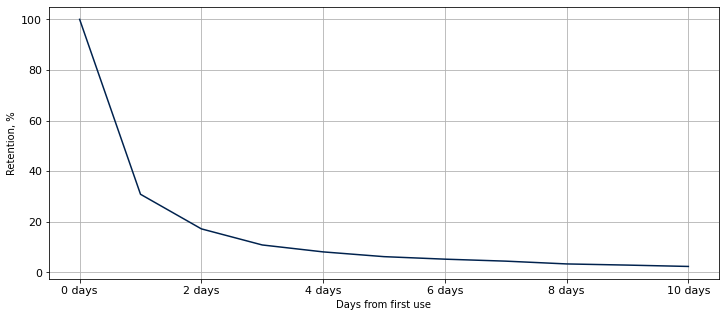

In [15]:
retention.astype({'day_number': 'str'}).plot(x = 'day_number', xlabel = 'Days from first use', 
               ylabel = 'Retention, %', y = 'retention_rate',
               figsize = (12, 5), colormap = 'cividis', 
                legend = False, grid = True, fontsize = 11)

<div style="border:solid DarkBlue 4px; padding: 15px"> 
Вторая часть задания:
    
С помощью SQL-запроса (без использования pandas) рассчитайте LTV 7-го дня с разбивкой по датам установки приложения.
    
Аналогично первой части, здесь в качестве установки будем принимать первую сессию пользователя.
    
Для корректного расчета нужно исключить из данных пользователей, установивших приложение менее, чем за 7 дней до последнего дня в данных.

In [16]:
connection = engine.connect()

sql_query = '''
--- Записываем в CTE список юзеров с их датами установки приложения, предварительно убрав слишком поздние сессии в WHERE.
WITH installations_cte AS
    (SELECT
        user_id, 
        min(date(session_start)) AS installation_date 
    FROM sessions
    WHERE date(session_start) <= (SELECT max(date(session_start, '-7 days')) from sessions)
    GROUP BY user_id)
SELECT
    installations_by_day.installation_date,
    purchases_7days,
    installations,
    purchases_7days / installations AS LTV_7days
FROM
--- В первом подзапросе отдельно аггрегируем кол-во установок по дням. Это необходимо, так как во втором подзапросе мы убираем
--- слишком поздние покупки и так теряем из данных пользователей, которые совершили одну покупку более, чем через 7 дней.
    (SELECT
        installation_date,
        count(user_ID) AS installations
    FROM installations_cte 
    GROUP BY installation_date
    ) AS installations_by_day
LEFT JOIN
--- Внутри второго поздапроса джоиним даты установки из CTE со списком покупок, убираем фильтром покупки позже 7го дня.
--- И группируем по датам установки.
    (SELECT
        installation_date,
        sum(revenue) AS purchases_7days
    FROM
        installations_cte
    LEFT JOIN
        purchases
    ON installations_cte.user_id = purchases.user_id
    WHERE julianday(date(event_dt)) - julianday(installation_date) < 8
    GROUP BY installation_date
    ) AS purchases
ON installations_by_day.installation_date = purchases.installation_date
'''
pd.read_sql_query(sql_query, connection)

,installation_date,purchases_7days,installations,LTV_7days
0,2013-08-14,154.72,583,0.265386
1,2013-08-15,287.45,673,0.427117
2,2013-08-16,200.60,737,0.272185
3,2013-08-17,159.72,823,0.194070
4,2013-08-18,176.66,808,0.218639
5,2013-08-19,124.75,746,0.167225
6,2013-08-20,125.75,604,0.208195


In [17]:
connection.close()

---

## Задание 2
В базе данных вы найдете таблицы campaigns. В ней содержатся данные о параметрах рекламных кампаний мобильного приложения за несколько последних месяцев.

Поля таблицы campaigns:

    ● campaign_id - уникальный идентификатор кампании;
    ● impressions - число показов рекламных объявлений в рамках кампании;
    ● cpm - CPM;
    ● clicks - число кликов по рекламным объявлениям;
    ● installs - число новых установок приложения в рамках кампании;
    ● ret_2 ... ret_14 - удержание пользователей, привлеченных в рамках кампании;
    ● ltv_1 ... ltv_14 - LTV пользователей, привлеченных в рамках кампании.
    
Используя эти данные:

    ● Рассчитайте окупаемость кампаний;
    ● Сегментируйте рекламные кампании, дайте характеристику выделенным сегментам;
    ● Для полученных сегментов сделайте прогноз окупаемости на горизонте 180 дней со
    дня установки;
    ● Дайте рекомендации отделу закупки трафика, оформите результат вашей работы в
    виде презентации.
    
В результате выполнения тестового задания у вас должен получиться один .ipynb-файл и один
файл с презентацией.

In [18]:
connection = engine.connect()
campaigns = pd.read_sql_query("SELECT * from campaigns", connection)
connection.close()

In [19]:
campaigns.sample(3)

,campaign_id,impressions,cpm,clicks,installs,ret_2,ret_3,ret_7,ret_14,ltv_1,ltv_3,ltv_7,ltv_14
1443,clkaa9y,1538,0.12,503,2,0.288274,0.139255,0.030443,0.008776,0.148152,0.296303,0.444455,0.578812
433,znvtaa5,207,0.52,5,1,0.616006,0.463981,0.256620,0.158079,0.318474,0.636948,0.955422,1.244243
1147,ek75p7z,665,0.14,71,1,0.790390,0.688783,0.516659,0.408362,0.108537,0.217073,0.325610,0.424040


In [20]:
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726 entries, 0 to 1725
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   campaign_id  1726 non-null   object 
 1   impressions  1726 non-null   int64  
 2   cpm          1726 non-null   float64
 3   clicks       1726 non-null   int64  
 4   installs     1726 non-null   int64  
 5   ret_2        1726 non-null   float64
 6   ret_3        1726 non-null   float64
 7   ret_7        1726 non-null   float64
 8   ret_14       1726 non-null   float64
 9   ltv_1        1726 non-null   float64
 10  ltv_3        1726 non-null   float64
 11  ltv_7        1726 non-null   float64
 12  ltv_14       1726 non-null   float64
dtypes: float64(9), int64(3), object(1)
memory usage: 175.4+ KB


In [21]:
campaigns.campaign_id.nunique()

1726

<div style="border:solid DarkBlue 4px; padding: 15px"> 

    
Добавляем столбец с затратами на кампании и столбец с доходами, посчитанный по последнему доступному LTV. 
    
И затем посчитаем окупаемость кампаний.

In [22]:
campaigns['cost'] = campaigns.cpm * campaigns.impressions / 1000
campaigns['revenue'] = campaigns.installs * campaigns.ltv_14
campaigns['roas'] =  (campaigns.revenue - campaigns.cost) / campaigns.cost

In [23]:
campaigns[:3]

,campaign_id,impressions,cpm,clicks,installs,ret_2,ret_3,ret_7,ret_14,ltv_1,ltv_3,ltv_7,ltv_14,cost,revenue,roas
0,j657p37,314,0.40,43,1,0.581712,0.423712,0.218500,0.127104,0.613814,1.227628,1.841441,2.398103,0.1256,2.398103,18.093180
1,bjrpd11,525,0.56,98,1,0.766486,0.656060,0.473983,0.363301,0.361621,0.723242,1.084864,1.412815,0.2940,1.412815,3.805492
2,bsm6lu6,114,0.45,22,1,0.766664,0.656301,0.474291,0.363622,0.212529,0.425059,0.637588,0.830329,0.0513,0.830329,15.185753


In [24]:
(campaigns.revenue.sum() - campaigns.cost.sum()) / campaigns.cost.sum()

4.350787883405553

<div style="border:solid DarkBlue 4px; padding: 15px"> 

    
Сделаем сегментацию кампаний по уровню ROAS по квартилям.

In [25]:
roas_quantiles = campaigns.roas.quantile(q=[0.25, 0.5, 0.75])
roas_quantiles

0.25     1.975523
0.50     5.554612
0.75    12.580633
Name: roas, dtype: float64

In [26]:
def ROASClass(value, quantiles_table):
    if value <= quantiles_table[0.25]:
        return 1
    elif value <= quantiles_table[0.50]:
        return 2
    elif value <= quantiles_table[0.75]: 
        return 3
    else:
        return 4

In [27]:
campaigns['roas_segment'] = campaigns['roas'].apply(ROASClass, args=[roas_quantiles])
campaigns[:5]

,campaign_id,impressions,cpm,clicks,installs,ret_2,ret_3,ret_7,ret_14,ltv_1,ltv_3,ltv_7,ltv_14,cost,revenue,roas,roas_segment
0,j657p37,314,0.40,43,1,0.581712,0.423712,0.218500,0.127104,0.613814,1.227628,1.841441,2.398103,0.12560,2.398103,18.093180,4
1,bjrpd11,525,0.56,98,1,0.766486,0.656060,0.473983,0.363301,0.361621,0.723242,1.084864,1.412815,0.29400,1.412815,3.805492,2
2,bsm6lu6,114,0.45,22,1,0.766664,0.656301,0.474291,0.363622,0.212529,0.425059,0.637588,0.830329,0.05130,0.830329,15.185753,4
3,u6pc8bj,289,0.53,69,1,0.864841,0.794413,0.665209,0.575300,0.325940,0.651881,0.977821,1.273413,0.15317,1.273413,7.313724,3
4,yrvnak2,724,0.68,17,1,0.801931,0.704792,0.538120,0.431535,0.328246,0.656493,0.984739,1.282423,0.49232,1.282423,1.604857,1


<div style="border:solid DarkBlue 4px; padding: 15px"> 

Теперь сделаем табличку с данными сегментов. Сначала нужно перемножить retention и LTV на установки каждой кампании, чтобы затем было возможно посчитать эти метрики для сегментов.

In [28]:
segments = campaigns

In [29]:
segments.iloc[:, 5:13][:0]

,ret_2,ret_3,ret_7,ret_14,ltv_1,ltv_3,ltv_7,ltv_14


In [30]:
segments.iloc[:, 5:13] = segments.iloc[:, 5:13].multiply(segments['installs'], axis="index")

In [31]:
segments = segments.groupby('roas_segment', as_index = False)\
                    .agg({'campaign_id':'count',
                       'impressions':'sum', 'clicks':'sum', 'installs':'sum', 'revenue':'sum', 'cost':'sum',
                       'ret_2': 'sum', 'ret_3': 'sum', 'ret_7': 'sum', 'ret_14': 'sum', 'ltv_1': 'sum', 'ltv_3': 'sum', 'ltv_7': 'sum', 'ltv_14': 'sum'})\
                    .rename(columns={'campaign_id':'campains_qntty'})
segments

,roas_segment,campains_qntty,impressions,clicks,installs,revenue,cost,ret_2,ret_3,ret_7,ret_14,ltv_1,ltv_3,ltv_7,ltv_14
0,1,432,2724800,450124,1075,496.966183,369.37177,542.015217,403.721619,255.186267,193.471415,127.202482,254.404965,381.607447,496.966183
1,2,431,1046183,248111,967,600.482485,137.98353,550.122744,430.339743,291.800250,229.525786,153.698311,307.396621,461.094932,600.482485
2,3,431,516900,137281,745,648.373483,70.58675,408.866814,313.671213,206.963211,161.538450,165.956396,331.912792,497.869188,648.373483
3,4,432,616647,171880,899,1572.552000,42.22347,399.005378,284.961430,172.005563,127.524064,402.507304,805.014607,1207.521911,1572.552000


<div style="border:solid DarkBlue 4px; padding: 15px"> 

Теперь можно проделать обратную операцию - переделить LTV и Retention на суммарные установки сегментов, получив корректные средневзвешенные метрики.

И далее добавим оставшиеся метрики.

In [32]:
segments.iloc[:, 7:15][:0]

,ret_2,ret_3,ret_7,ret_14,ltv_1,ltv_3,ltv_7,ltv_14


In [33]:
segments.iloc[:, 7:15] = segments.iloc[:, 7:15].div(segments['installs'], axis="index")
segments

,roas_segment,campains_qntty,impressions,clicks,installs,revenue,cost,ret_2,ret_3,ret_7,ret_14,ltv_1,ltv_3,ltv_7,ltv_14
0,1,432,2724800,450124,1075,496.966183,369.37177,0.504200,0.375555,0.237383,0.179973,0.118328,0.236656,0.354984,0.462294
1,2,431,1046183,248111,967,600.482485,137.98353,0.568896,0.445026,0.301758,0.237359,0.158943,0.317887,0.476830,0.620975
2,3,431,516900,137281,745,648.373483,70.58675,0.548815,0.421035,0.277803,0.216830,0.222760,0.445521,0.668281,0.870300
3,4,432,616647,171880,899,1572.552000,42.22347,0.443832,0.316976,0.191330,0.141851,0.447728,0.895456,1.343183,1.749224


In [34]:
segments['roas'] =  (segments.revenue - segments.cost) / segments.cost
segments['cpm'] = segments.cost / segments.impressions * 1000
segments['ctr'] = segments.clicks / segments.impressions
segments['cr'] = segments.installs / segments.clicks
segments

,roas_segment,campains_qntty,impressions,clicks,installs,revenue,cost,ret_2,ret_3,ret_7,ret_14,ltv_1,ltv_3,ltv_7,ltv_14,roas,cpm,ctr,cr
0,1,432,2724800,450124,1075,496.966183,369.37177,0.504200,0.375555,0.237383,0.179973,0.118328,0.236656,0.354984,0.462294,0.345436,0.135559,0.165195,0.002388
1,2,431,1046183,248111,967,600.482485,137.98353,0.568896,0.445026,0.301758,0.237359,0.158943,0.317887,0.476830,0.620975,3.351842,0.131892,0.237158,0.003897
2,3,431,516900,137281,745,648.373483,70.58675,0.548815,0.421035,0.277803,0.216830,0.222760,0.445521,0.668281,0.870300,8.185484,0.136558,0.265585,0.005427
3,4,432,616647,171880,899,1572.552000,42.22347,0.443832,0.316976,0.191330,0.141851,0.447728,0.895456,1.343183,1.749224,36.243552,0.068473,0.278733,0.005230


<div style="border:solid DarkBlue 4px; padding: 15px"> 

Характеристика выделенным сегментам:
    
- 1 сегмент проигрывает остальным по всем показателям. Но эти кампании дают самую большую долю трафика, поэтому их сокращение испортит динамику притока новых пользователей. Необходимо более детально проанализировать кампании 1 сегмента, понять причины их неэффективности и постараться оптимизировать.

- сегмент 2 тоже имеет достаточно высокий показатель окупаемости, сравним с 3им по удержанию и LTV. Но проигрывает из-за более низких CTR и конверсии в установки.
    Нужно оптимизировать кампании из 2 сегмента.

- 3 сегмент имеет все показатели выше среднего. Но при этом самую низкую долю трафика - нужно стараться увеличить объемы. Уровень окупаемости позволяют делать это в том числе за счет увеличения CPM с большим запасом. 
    
- 4 сегмент показывает крайне высокий уровень окупаемости и по многим показателям превосходит всех остальных. Но при этом имеет самый низкий уровень удержания. Необходимо понять причины этого.

<div style="border:solid DarkBlue 4px; padding: 15px"> 

В данных нет ни детальной динамики кампаний, ни исторических данных.
    
Поэтому возможность построить прогноз окупаемости на горизонте 180 дней вижу только на имеюшейся динамике LTV. 
А точнее - на соотношении добавленной LTV второй недели к накопленной LTV первой недели.

In [178]:
segments['ltv_koef'] = (segments.ltv_14 - segments.ltv_7) / segments.ltv_7
segments

,roas_segment,campains_qntty,impressions,clicks,installs,revenue,cost,ret_2,ret_3,ret_7,ret_14,ltv_1,ltv_3,ltv_7,ltv_14,roas,cpm,ctr,cr,ltv_koef
0,1,432,2724800,450124,1075,496.966183,369.37177,0.504200,0.375555,0.237383,0.179973,0.118328,0.236656,0.354984,0.462294,0.345436,0.135559,0.165195,0.002388,0.302297
1,2,431,1046183,248111,967,600.482485,137.98353,0.568896,0.445026,0.301758,0.237359,0.158943,0.317887,0.476830,0.620975,3.351842,0.131892,0.237158,0.003897,0.302297
2,3,431,516900,137281,745,648.373483,70.58675,0.548815,0.421035,0.277803,0.216830,0.222760,0.445521,0.668281,0.870300,8.185484,0.136558,0.265585,0.005427,0.302297
3,4,432,616647,171880,899,1572.552000,42.22347,0.443832,0.316976,0.191330,0.141851,0.447728,0.895456,1.343183,1.749224,36.243552,0.068473,0.278733,0.005230,0.302297


In [179]:
def ltv180_func(ltv_start, koef):
    x = 0
    y = ltv_start
    weeks = 180 / 7
    while weeks > 0:
        if weeks > 1:
            x = x + y
            weeks = weeks - 1
            y = y * koef
        else:
            x = x + y * weeks
            weeks = weeks  - 1
    return(x)

In [181]:
segments['ltv_180'] = segments.apply(lambda x: ltv180_func(x['ltv_7'], x['ltv_koef']), axis=1)

In [185]:
segments['revenue_180'] = segments.installs * segments.ltv_180
segments['roas_180'] =  (segments.revenue_180 - segments.cost) / segments.cost
segments[:3]

,roas_segment,campains_qntty,impressions,clicks,installs,revenue,cost,ret_2,ret_3,ret_7,...,ltv_7,ltv_14,roas,cpm,ctr,cr,ltv_koef,ltv_180,revenue_180,roas_180
0,1,432,2724800,450124,1075,496.966183,369.37177,0.504200,0.375555,0.237383,...,0.354984,0.462294,0.345436,0.135559,0.165195,0.002388,0.302297,0.508789,546.948162,0.480752
1,2,431,1046183,248111,967,600.482485,137.98353,0.568896,0.445026,0.301758,...,0.476830,0.620975,3.351842,0.131892,0.237158,0.003897,0.302297,0.683429,660.875535,3.789525
2,3,431,516900,137281,745,648.373483,70.58675,0.548815,0.421035,0.277803,...,0.668281,0.870300,8.185484,0.136558,0.265585,0.005427,0.302297,0.957830,713.583132,9.109307


In [188]:
segments[['impressions', 'roas_segment', 'cost', 'ltv_180', 'revenue_180', 'roas_180']]

,impressions,roas_segment,cost,ltv_180,revenue_180,roas_180
0,2724800,1,369.37177,0.508789,546.948162,0.480752
1,1046183,2,137.98353,0.683429,660.875535,3.789525
2,516900,3,70.58675,0.957830,713.583132,9.109307
3,616647,4,42.22347,1.925150,1730.710170,39.989293
